In [150]:
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.ndimage import maximum_filter, minimum_filter
from skimage.filters import threshold_otsu
from sklearn.metrics import precision_score, recall_score, f1_score
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm

# Setup

Get paths of the relevant files

In [151]:
image_dir_hw = "data/raw/dibco2009/DIBC02009_Test_images-handwritten"
image_dir_pr = "data/raw/dibco2009/DIBCO2009_Test_images-printed"
output_dir = "data/processed/"
results_dir = "results"

In [152]:
all_hw = sorted(glob(os.path.join(image_dir_hw, "*.tif")))
all_pr = sorted(glob(os.path.join(image_dir_pr, "*.tif")))

# Split into images and ground truth
image_paths_hw = [p for p in all_hw if "_gt" not in p]
gt_paths_hw    = [p for p in all_hw if "_gt" in p]

image_paths_pr = [p for p in all_pr if "_gt" not in p]
gt_paths_pr    = [p for p in all_pr if "_gt" in p]

Load the data

In [153]:
images_hw = {
    os.path.basename(img_path)[:-4]: (
        cv2.imread(img_path, cv2.IMREAD_GRAYSCALE),
        cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    )
    for img_path, gt_path in zip(image_paths_hw, gt_paths_hw)
}
images_pr = {
    os.path.basename(img_path)[:-4]: (
        cv2.imread(img_path, cv2.IMREAD_GRAYSCALE),
        cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    )
    for img_path, gt_path in zip(image_paths_pr, gt_paths_pr)
}

# First Look

In [154]:
image_hw = images_hw[next(iter(images_hw))]
image_pr = images_pr[next(iter(images_pr))]

Handwritten image

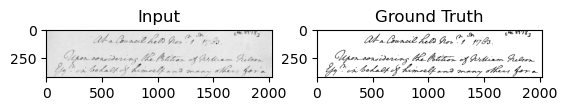

In [155]:
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(image_hw[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(image_hw[1], cmap='gray')
plt.show()

Printed Image

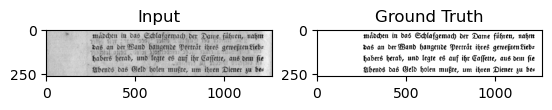

In [156]:
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(image_pr[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(image_pr[1], cmap='gray')
plt.show()

# Binarization

In [157]:
def binarize_su(image, window_size=25, N_min=6):

    # Step 1: Compute local max and min in 3×3 neighborhood
    f_max = maximum_filter(image, size=3)
    f_min = minimum_filter(image, size=3)

    # Step 2: Compute contrast (formula in the paper)
    contrast = (f_max - f_min) / (f_max + f_min + 1e-5)

    # Step 3: Threshold contrast image globally using Otsu to detect stroke boundaries
    thresh = threshold_otsu(contrast)
    hc_mask = (contrast >= thresh).astype(np.uint8)

    # Step 4: Prepare for local adaptive binarization
    pad = window_size // 2
    I_padded = np.pad(image, pad, mode='reflect')  # pad image
    H_padded = np.pad(hc_mask, pad, mode='constant')  # pad high contrast mask
    binarized = np.zeros_like(image)

    # Step 5: For each pixel, check its local neighborhood
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            roi_img = I_padded[i:i+window_size, j:j+window_size]
            roi_mask = H_padded[i:i+window_size, j:j+window_size]

            # Extract intensity values of high contrast pixels
            hc_vals = roi_img[roi_mask == 1]

            # If enough high contrast pixels are found, apply local threshold
            if len(hc_vals) >= N_min:
                mean = hc_vals.mean()
                std = hc_vals.std()
                if image[i, j] <= mean + std / 2:
                    binarized[i, j] = 255  # mark as foreground (text)

    return binarized

# Evaluation

In [158]:
results_hw = {}

# Loop over all pairs of images
for _, (name, (img, img_gt)) in enumerate(tqdm(images_hw.items())):

    # Apply Su et al. binarization
    bin_img = binarize_su(img, window_size=31, N_min=4)

    # Save binarized result next to original file
    out_name = name + "_hw_bin_su.tif"
    cv2.imwrite(os.path.join(output_dir, out_name), bin_img)

    # Prepare binary masks for evaluation
    gt_bin = (img_gt < 128).astype(np.uint8)
    pred_bin = (bin_img > 128).astype(np.uint8)

    # Calculate evaluation metrics and store them
    results_hw[name] = {
        "F1": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Precision": precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Recall": recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "PSNR": psnr(img_gt, bin_img, data_range=255)
    }

100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


In [159]:
results_pr = {}

# Loop over all pairs of images
for _, (name, (img, img_gt)) in enumerate(tqdm(images_pr.items())):

    # Apply Su et al. binarization
    bin_img = binarize_su(img, window_size=31, N_min=4)

    # Save binarized result
    out_name = name + "_pr_bin_su.tif"
    cv2.imwrite(os.path.join(output_dir, out_name), bin_img)

    # Prepare binary masks for evaluation
    gt_bin = (img_gt < 128).astype(np.uint8)
    pred_bin = (bin_img > 128).astype(np.uint8)

    # Calculate evaluation metrics
    results_pr[name] = {
        "F1": f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Precision": precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "Recall": recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0),
        "PSNR": psnr(img_gt, bin_img, data_range=255)
    }

100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Save results

In [160]:
df_hw = pd.DataFrame.from_dict(results_hw, orient="index")
df_pr = pd.DataFrame.from_dict(results_pr, orient="index")
df_hw.index.name = "Name"
df_pr.index.name = "Name"
df_hw.reset_index(inplace=True)
df_pr.reset_index(inplace=True)

In [161]:
df_hw

,Name,F1,Precision,Recall,PSNR
0,dibco_img0001,0.243408,0.984640,0.138869,0.258317
1,dibco_img0002,0.101179,0.760924,0.054192,0.091418
2,dibco_img0003,0.366943,0.867006,0.232718,0.352348
3,dibco_img0004,0.163987,0.768317,0.091789,0.308884
4,dibco_img0005,0.073164,0.985064,0.037993,0.162384


In [162]:
df_pr

,Name,F1,Precision,Recall,PSNR
0,dibco_img0006,0.466426,0.850740,0.321287,0.403329
1,dibco_img0007,0.155683,0.941351,0.084858,0.920645
2,dibco_img0008,0.241511,0.948345,0.138375,0.698165
3,dibco_img0009,0.314811,0.937473,0.189168,0.391100
4,dibco_img0010,0.306456,0.638178,0.201643,0.622280


In [163]:
df_hw.to_csv(f"{results_dir}/results_hr_su_method.csv", index=False)
df_pr.to_csv(f"{results_dir}/results_pr_su_method.csv", index=False)